# Full-Learning PC Networks
Purpose: To see if we can learn not only (v)<->(e) connections, but also the (e)<->(v) connections. Those connections have previously been set to 1:1 identity mappings. But here they start as random connection weights, and learn using the same update rule as the other learning connections.

In [1506]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import torch
from torch.utils.data import Dataset, DataLoader
from IPython.display import display
from ipywidgets import FloatProgress

%load_ext autoreload
%autoreload 1
%aimport PCNetwork
%aimport PCLayer
%aimport PCConnection

dtype = torch.float32
if torch.cuda.is_available():
    device = torch.device("cuda:0") # Uncomment this to run on GPU
else:
    device = torch.device("cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Dataset

In [2038]:
# Make my own dataset
A = torch.tensor([[ 1.3874, -0.2003,  0.4514],
                  [-0.0967, -0.4015,  1.3332]], dtype=torch.float32, device=device)
n_classes, top_dim = np.shape(A)
B = torch.eye(n_classes, device=device)

In [1507]:
# Make my own dataset
A = torch.eye(2, dtype=torch.float32, device=device)
n_classes, top_dim = np.shape(A)
B = torch.eye(n_classes, device=device)

In [2128]:
# This creates a dataset

n_classes = 3
hidden_dim = 5
sensory_dim = 10

seed = 2950
torch.manual_seed(seed)
np.random.seed(seed)
B = torch.eye(n_classes)
X = 3.*(torch.rand((sensory_dim, n_classes)) - 0.5)
A = X.T
print('Input vectors')
print(A)
print('Target vectors')
print(B)

Input vectors
tensor([[ 0.3232, -0.9563,  0.5234,  1.4845, -0.3955,  0.9563, -0.8818, -1.4115,
          1.3157,  0.8915],
        [ 1.2468,  0.5938,  0.8025, -1.0985, -1.3189, -0.9960,  0.8459, -0.2334,
          0.5250,  1.1660],
        [-0.8239, -1.1012,  0.0545,  0.2905, -0.4973,  1.3367, -1.4346,  0.9836,
         -0.9238, -0.5371]])
Target vectors
tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])


In [1358]:
class SimpleDataset(Dataset):
    def __init__(self, A, B, n=300, noise=0.1):
        self.samples = []
        self.n_classes = len(A)
        self.input_dim = len(A[0])
        for i in range(n):
            r = np.random.randint(self.n_classes)
            #sample = [A[r]+noise*torch.randn_like(A[r]), B[r]]
            sample = [A[r]+noise*torch.randn_like(A[r]), B[r]+noise*torch.randn_like(B[r])]
            self.samples.append(sample)
        
    def __getitem__(self, idx):
        return self.samples[idx]
        
    def __len__(self):
        return len(self.samples)
    
    def Inputs(self):
        x = []
        for s in self.samples:
            x.append(s[0])
        return torch.stack(x)
    
    def Targets(self):
        t = []
        for s in self.samples:
            t.append(s[1])
        return torch.stack(t)
            
    def InputsOfClass(self, c):
        x = []
        for s in self.samples:
            if torch.argmax(s[1])==c:
                x.append(s[0])
        return torch.stack(x)
    
    def ClassMean(self):
        xmean = []
        for c_idx in range(self.n_classes):
            classmean = torch.mean(self.InputsOfClass(c_idx), axis=0)
            xmean.append(classmean)
        return torch.stack(xmean)
            
    def Plot(self, labels=[], idx=(1,2), equal=True):
        X = self.Inputs()
        if len(labels)==0:
            labels = self.Targets()
        colour_options = ['y', 'r', 'g', 'b', 'k']
        cidx = torch.argmax(labels, axis=1)
        colours = [colour_options[k] for k in cidx]
        plt.scatter(X[:,idx[0]], X[:,idx[1]], color=colours, marker='.')

        if equal:
            plt.axis('equal');

In [2129]:
blah = SimpleDataset(A, B, n=200, noise=0.1)

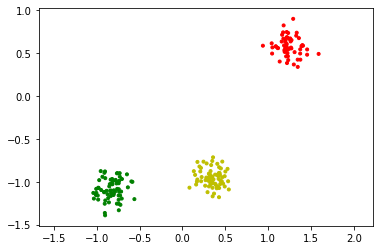

In [2130]:
blah.Plot(idx=(0,1));

# Create Network

In [2131]:
ds = SimpleDataset(A, B, n=200, noise=0.1)
dl = DataLoader(ds, batch_size=4, shuffle=True)

In [2042]:
net = PCNetwork.PCNetwork()
net.AddLayer(PCLayer.PCLayer(n=ds.input_dim))  # v0 input
net.AddLayer(PCLayer.PCLayer(n=ds.n_classes))  # e1 error
net.AddLayer(PCLayer.PCLayer(n=ds.n_classes))  # v1 class

af0 = 'identity'
af = 'tanh'
net.Connect(v_idx=0, e_idx=1, type='general', sym=True, act_text=af0)
#net.Connect(v_idx=2, e_idx=1, type='1to1')
net.Connect(v_idx=2, e_idx=1, type='general', sym=True, act_text=af)
#net.con[1].SetIdentity()

net.SetTau(0.05)

# Training

In [2043]:
#net.Plot(idx=0);

In [2116]:
net.ClearHistory()
net.Probe(True)
net.Learning(True)
net.SetGamma(0.1)

# Connection (v0)--(e1)
net.con[0].SetRandom(random=1.)

# Connection (e1)--(v1)
net.con[1].SetRandom(random=1.)
#net.con[1].SetIdentity(mult=0.1)
net.con[1].Learning(False)

#net.lyr[1].SetBias(random=0.5)

net.SetDynamicWeightDecay(0.1, 0.8)
net.SetActivityDecay(0.0)
net.SetBlackout(0.)

In [2117]:
M0 = deepcopy(net.con[0].M)
print(M0)
M1 = deepcopy(net.con[1].M)
print(M1)

tensor([[-0.6531,  0.0674],
        [-1.4154, -0.1869],
        [-0.2667, -0.9841]])
tensor([[ 0.0604,  1.0527],
        [-0.6953, -0.1839]])


In [2118]:
net.SetRepelSmallWeights(0.0)

In [2101]:
net.con[0].M = M0.clone().detach()
net.con[0].W = M0.transpose(1,0).clone().detach()
net.con[1].M = M1.clone().detach()
net.con[1].W = M1.transpose(1,0).clone().detach()

In [2119]:
net.ClearHistory()

In [2120]:
net.Learning(True)
net.con[1].Learning(False)
net.Learn(dl, T=1., epochs=2)

Epoch: 0 weight decay = 0.1
Epoch: 1 weight decay = 0.02


In [2121]:
print(net.con[0].M)
print(net.con[1].M)

tensor([[ 0.2173,  0.6463],
        [ 0.0752, -0.1072],
        [-0.3726, -0.0622]])
tensor([[ 0.0604,  1.0527],
        [-0.6953, -0.1839]])


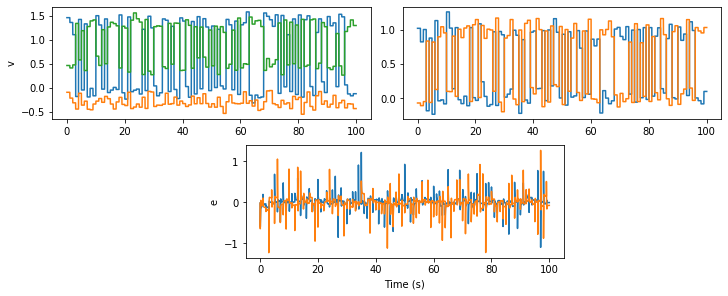

In [2122]:
net.Plot(idx=0);

# Classification

In [2123]:
net.Reset(random=1.)
net.SetActivityDecay( 0. )
y = net.Predict(ds.Inputs(), T=10.)
print(y[:16])
print(ds.Targets()[:16])

tensor([[ 1.1362, -0.1148],
        [ 1.3576, -0.1306],
        [-0.0039,  1.1079],
        [ 1.0403, -0.0639],
        [ 0.0603,  0.9467],
        [ 0.9873, -0.1466],
        [ 1.1483, -0.1236],
        [ 1.0994, -0.1243],
        [ 0.0892,  0.8395],
        [ 1.0582, -0.0530],
        [ 0.0245,  1.2267],
        [ 0.0295,  1.1168],
        [ 1.2786, -0.1225],
        [ 1.3289, -0.1092],
        [ 0.0199,  1.1595],
        [ 0.9211, -0.1731]])
tensor([[ 0.9879, -0.0683],
        [ 1.0254, -0.0218],
        [ 0.0906,  1.0783],
        [ 0.7295, -0.0308],
        [-0.1072,  1.0529],
        [ 0.8685, -0.1623],
        [ 0.9841, -0.1211],
        [ 1.1299,  0.1286],
        [-0.1368,  0.9199],
        [ 0.9312, -0.0905],
        [-0.0477,  0.9379],
        [-0.0791,  1.0957],
        [ 0.9843,  0.0847],
        [ 1.1558, -0.1027],
        [-0.0659,  0.8586],
        [ 0.9237, -0.1949]])


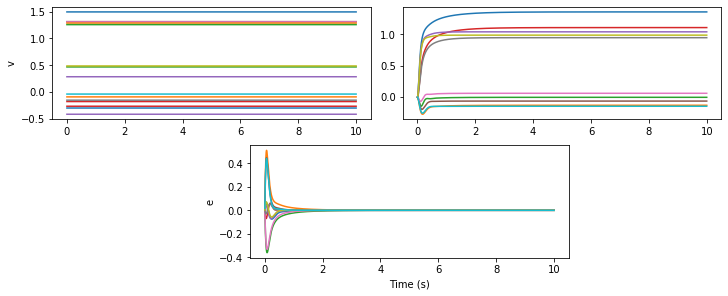

In [2124]:
net.Plot(idx=[1,2,3,4,5]);

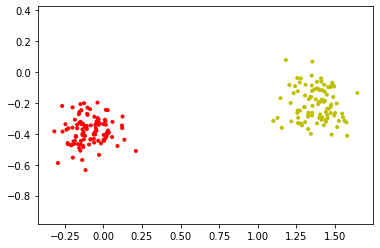

In [2125]:
ds.Plot(labels=y, idx=(0,1))

# Generation

In [2126]:
net.Reset(random=1.)
net.SetActivityDecay( (lambda t: 0.2*np.exp(-t)))
X = net.Generate(ds.Targets(), T=20)

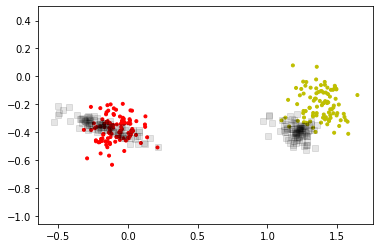

In [2127]:
sidx = (0,1)
ds.Plot(idx=sidx)
plt.plot(X[:,sidx[0]], X[:,sidx[1]], 's', color=[0,0,0,0.1]);

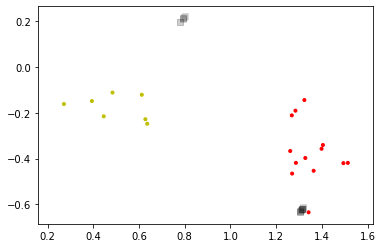

In [207]:
sidx = (2,1)
ds.Plot(idx=sidx)
plt.plot(X[:,sidx[0]], X[:,sidx[1]], 's', color=[0,0,0,0.1]);

In [208]:
X[:6]

tensor([[ 0.1661, -0.6225,  1.3107],
        [ 0.1514, -0.6168,  1.3152],
        [ 0.1892, -0.6314,  1.3035],
        [ 0.1600, -0.6201,  1.3126],
        [ 0.1738, -0.6254,  1.3083],
        [ 0.1940, -0.6332,  1.3020]])

In [137]:
A

tensor([[ 1.3874, -0.2003,  0.4514],
        [-0.0967, -0.4015,  1.3332]])